In [16]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## 2D Ising Model

We simulate a $L \times L$ 2D Ising model at different temperature using the Metropolis algorithm. Each spin $\sigma_j \in \{-1, +1\}$, and the system has $2^L$ possible configurations, where $L$ is the number of lattice sites.

Hamiltonian (with external magnetic field $h$):
$$
H(\boldsymbol{\sigma}) = -J \sum_{\langle i, j \rangle} \sigma_i \sigma_j - h \sum_j \sigma_j
$$

Metropolis Algorithm:
1. Pick a random spin.
2. Compute energy difference $\Delta H$ from flipping the spin.
3. Accept the flip with probability:
   $$
   P_{\text{accept}} =
   \begin{cases}
   1 & \text{if } \Delta H \leq 0 \\
   e^{-\beta \Delta H} & \text{if } \Delta H > 0
   \end{cases}
   $$

The Balance Condition:
$$
\frac{A(\mu, \nu)}{A(\nu, \mu)} = e^{-\beta(H_\nu - H_\mu)}
$$


In [17]:
def spin_grid_animation(spin_grids, T, J, h, mu, save_path=None):


    fig, ax = plt.subplots()
    
    def update(frame):
        ax.clear()
        ax.imshow(spin_grids[frame], cmap='plasma', vmin=-1, vmax=1)
        ax.set_title(f'Spin Grid Evolution at T={T:.2f}K with h={h:.2}T outside field')
        ax.axis('off')

    ani = FuncAnimation(fig, update, frames=len(spin_grids), interval = 1)
    
    if save_path:
        ani.save(save_path, writer='imagemagick')
    
    return HTML(ani.to_jshtml())

In [18]:
class IsingModel:
    def __init__(self, grid_size, temperature, J, h, mu):
        self.grid_size = grid_size
        self.temperature = temperature
        self.spins = np.random.choice([-1, 1], size=(grid_size, grid_size))
        self.J = J  
        self.h = h
        self.mu = mu

    def energy(self):
        energy = 0
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                s = self.spins[i, j]
                s_neighbors = (
                    self.spins[(i + 1) % self.grid_size, j] +
                    self.spins[i, (j + 1) % self.grid_size] +
                    self.spins[(i - 1) % self.grid_size, j] +
                    self.spins[i, (j - 1) % self.grid_size]
                )
                energy += -(1/2) * self.J * s * s_neighbors - self.h * self.mu * s

        return energy    
    
    def delta_energy(self, i, j):
        s = self.spins[i, j]
        s_neighbors = (
            self.spins[(i + 1) % self.grid_size, j] +
            self.spins[i, (j + 1) % self.grid_size] +
            self.spins[(i - 1) % self.grid_size, j] +
            self.spins[i, (j - 1) % self.grid_size]
        )
        return 2 * s * (self.J * s_neighbors + self.h * self.mu)

    def magnetization(self):
        return np.mean(self.spins)
    
    def susceptibility(self, magnetizations):
        return (np.mean(np.array(magnetizations)**2) - np.array(np.mean(magnetizations))**2) / self.temperature        
    
    def specific_heat(self, energies):
        return (np.mean(np.array(energies)**2) - np.array(np.mean(energies))**2) / (self.temperature**2)

In [19]:
def equilibrium(energies, eps, window): # az energia lista utolsó [window] darab eleménél vizsgálja, hogy mennyit változnak
    
    if len(energies) < window:
        return False
        
    recent = energies[-window:]
    diffs = np.abs(np.diff(recent))
    
    return np.all(diffs < eps)

In [20]:
def Metropolis_hastings(ising_model, steps, scalings, eps=1e-4, window=10):

    (J_phys,  mu_phys) = scalings
    energies = []
    magnetizations = []
    
    spin_grids = []
    

    step = 0
    while step < steps and not equilibrium(energies, eps, window):   
    
        i, j = np.random.randint(0, ising_model.grid_size, size=2)
        delta_E = ising_model.delta_energy(i, j)

        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / (ising_model.temperature)):
            ising_model.spins[i, j] *= -1

        energies.append(ising_model.energy())
        magnetizations.append(ising_model.magnetization())
        

        if step % 20 == 0:
            spin_grids.append(ising_model.spins.copy())

        step += 1

    print(f"Steps taken: {step}, Total steps: {steps}, Equilibrium reached: {equilibrium(energies, eps, window)}")

    E = np.mean(energies[-10:]) # az adott T-hez tartozó egyensúlyi energia
    M = np.mean(magnetizations[-10:]) # az adott T-hez tartozó egyensúlyi mágnesezettség
    X = ising_model.susceptibility(magnetizations[-10:]) # a stabil mágnesezettségekből számolt szuszceptibilitás
    C = ising_model.specific_heat(energies[-10:]) # a stabil energiákból számolt fajhő

    return E * J_phys, M * mu_phys, np.array(spin_grids), X, C #vmi dimenziósító szorzó kéne a szuszceptibilitásnak meg fajhőnek

In [21]:
def plot(T, energies, magnetization, susceptibility, specific_heat):
    
    f = pl.figure(figsize=(18, 10))
    
    sp =  f.add_subplot(2, 2, 1)
    pl.scatter(T, energies, s=50, marker='o', color='IndianRed')
    pl.xlabel("Temperature", fontsize=20)
    pl.ylabel("Energy ", fontsize=20)     
    pl.axis('tight')
    
    sp =  f.add_subplot(2, 2, 2)
    pl.scatter(T, abs(magnetization), s=50, marker='o', color='RoyalBlue')
    pl.xlabel("Temperature", fontsize=20) 
    pl.ylabel("Magnetization ", fontsize=20)   
    pl.axis('tight')
    
    sp =  f.add_subplot(2, 2, 3)
    pl.scatter(T, susceptibility, s=50, marker='o', color='IndianRed')
    pl.xlabel("Temperature", fontsize=20)  
    pl.ylabel("Specific Heat ", fontsize=20)   
    pl.axis('tight')   
    
    sp =  f.add_subplot(2, 2, 4)
    pl.scatter(T, specific_heat, s=50, marker='o', color='RoyalBlue')
    pl.xlabel("Temperature", fontsize=20) 
    pl.ylabel("Susceptibility", fontsize=20)   
    pl.axis('tight')

Steps taken: 5352, Total steps: 10000, Equilibrium reached: True


MovieWriter imagemagick unavailable; using Pillow instead.


FileNotFoundError: [WinError 3] A rendszer nem találja a megadott elérési utat: 'C:\\Users\\akosc\\tudprog\\ising_model_nhf'

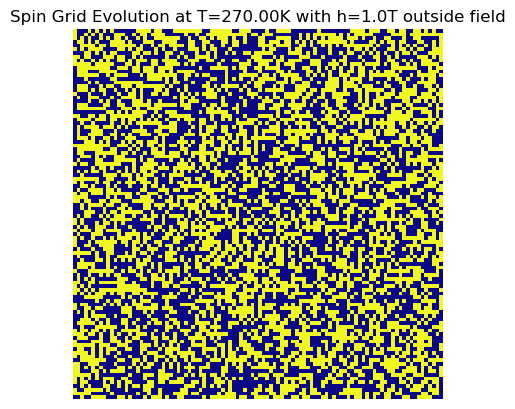

In [22]:
k_B = 1.380649e-23       # J/K
J_phys = 2.0e-21         # J
mu_phys = 9.2740100783e-24      # J/T
T_phys = 270             # K
h_phys = 1.0             # T


T = T_phys * (k_B / J_phys)         # 1
h = h_phys * (mu_phys / J_phys)     # 1
J = 1.0                              
mu = 1.0  


ising_model = IsingModel(grid_size=100, temperature=T, J=J, h=h, mu=mu)

steps = 10000
scalings = (J_phys, mu_phys)
energies, magnetizations, spin_grids, X, C = Metropolis_hastings(ising_model, steps, scalings)


path = r'C:\Users\akosc\tudprog\ising_model_nhf\ising_model_animation_270K.gif'
spin_grid_animation(spin_grids, T_phys, J_phys, h_phys, mu_phys, save_path=path)

MovieWriter imagemagick unavailable; using Pillow instead.


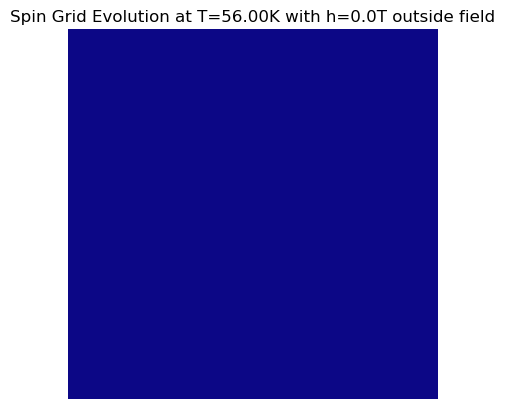

In [ ]:
k_B = 1.380649e-23       # J/K
J_phys = 2.0e-21         # J
mu_phys = 9.2740100783e-24      # J/T
T_phys = 56             # K
h_phys = 0.            # T


T = T_phys * (k_B / J_phys)         # 1
h = h_phys * (mu_phys / J_phys)     # 1
J = 1.0                              
mu = 0.


ising_model = IsingModel(grid_size=100, temperature=T, J=J, h=h, mu=mu)

steps = 50000
scalings = (J_phys, mu_phys)
energies, magnetizations, spin_grids = Metropolis_hastings(ising_model, steps, scalings)

path = r'C:\Users\akosc\tudprog\ising_model_nhf\ising_model_animation_56.gif'
spin_grid_animation(spin_grids, T_phys, J_phys, h_phys, mu_phys, save_path=path)

[0. 0. 0. 0. 0.]


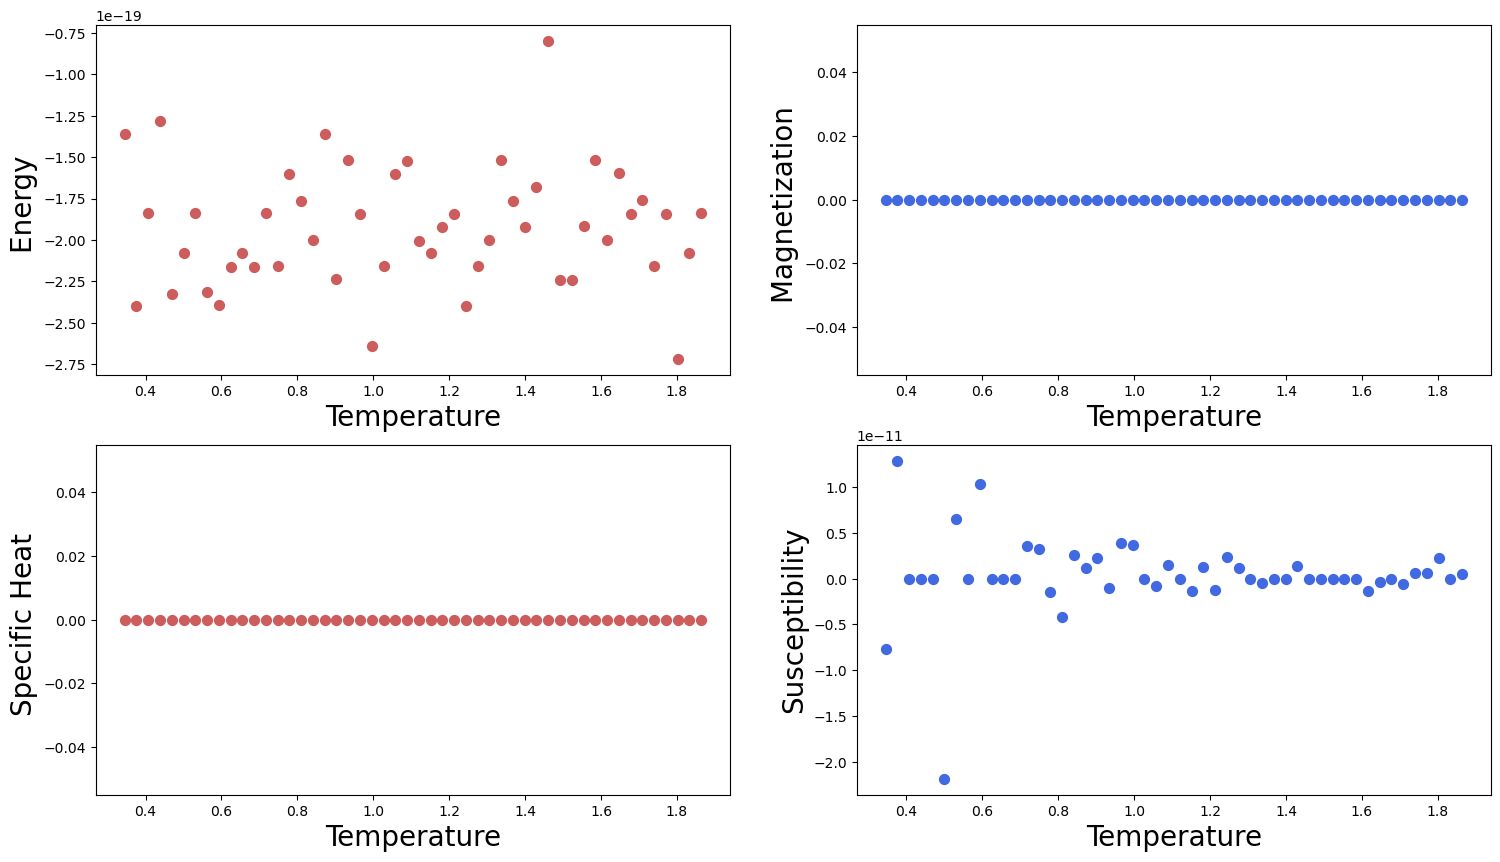

In [ ]:
k_B = 1.380649e-23       # J/K
J_phys = 2.0e-21         # J
mu_phys = 9.2740100783e-24      # J/T

nT = 50 # hőmérséklet adatpontok száma
T_phys = np.linspace(50, 270, nT)             # K
h_phys = 1.0             # T


T = T_phys * (k_B / J_phys)         # 1
h = h_phys * (mu_phys / J_phys)     # 1
J = 1.0                              
mu = 1.0  





steps = 5000
scalings = (J_phys, mu_phys)


energies, magnetization, susceptibility, specific_heat = np.zeros(nT), np.zeros(nT), np.zeros(nT), np.zeros(nT)

for kT in range(nT):
    ising_model = IsingModel(grid_size=10, temperature=T[kT], J=J, h=h, mu=mu)
    E, M, spin_grids, X, C = Metropolis_hastings(ising_model, steps, scalings)
    energies[kT] = E
    magnetization[kT] = M
    susceptibility[kT] = X
    specific_heat[kT] = C

print(magnetization[-5:])

plot(T, energies, magnetization, susceptibility, specific_heat)
